# Defining your own problem

This notebook shows you how to define your own differential equation problem and solve it using FBPINNs (and compare to a standard PINN).

## Problem overview

The example problem we will define and solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/ (image credits: https://commons.wikimedia.org/wiki/User:Jahobr)

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d4/Damped_oscillation_graph2.svg" width="280">

## Workflow overview

The workflow for defining and solving your own problem consists of the following steps:
1. Define your own custom `Problem` class
2. Initialise a `Constants` object with this new problem
3. Train a FBPINN / PINN using this `Constants` object

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from fbpinns import problems
from fbpinns import losses
from fbpinns import boundary_conditions
from fbpinns import constants
from fbpinns import active_schedulers

from fbpinns.trainers.pinn_trainer import PINNTrainer

from fbpinns.common.utils import init_logging

init_logging()

%load_ext autoreload
%autoreload 2


## 1. Define your own custom `Problem` class
First, you must define your own custom problem class that defines the differential equation problem. This problem class should be passed to the main trainer classes (`main.FBPINNTrainer` and `main.PINNTrainer`) via the `constants.Constants` object when training FBPINNs and PINNs.

### Base `Problem` class

All problem classes must inherit the `problems._Problem` base class and define the following methods:

```python
class _Problem:
    "Base problem class to be inherited by different problem classes"
    
    @property
    def name(self):
        "Defines a name string (only used for labelling automated training runs)"
        raise NotImplementedError
    
    def __init__(self):
        raise NotImplementedError
    
    def physics_loss(self, x, *yj):
        "Defines the PINN physics loss to train the NN"
        raise NotImplementedError
        
    def get_gradients(self, x, y):
        "Returns the gradients yj required for this problem"
        
    def boundary_condition(self, x, *yj, args):
        "Defines the hard boundary condition to be applied to the NN ansatz"
        raise NotImplementedError
    
    def exact_solution(self, x, batch_size):
        "Defines exact solution if it exists"
        return None
```

### Description of required methods

A description of the inputs and outputs of each method is below:

``def name(self):``
This should return a string and is a helper method which can be used for automated naming of training runs.

``def __init__(self):``
This method initialises the problem class. The only requirement of this method is that it should define an attribute `self.d = (d, d_u)` which is a tuple of two integers which defines the dimensionality of the input variable ($x$) and the solution ($u(x)$). This is used when initialising the subdomain neural networks and other parts of the training code. You can also optionally use this method to store any other useful variables too.

``def physics_loss(self, x, *yj):``
This method defines the physics loss function used to train the FBPINN / PINN. Because we use a hard constraining operator in the solution ansatz, we only need to use this physics loss to train FBPINNs / PINNs. This method is passed `torch.Tensor` batches of input variables, the approximate FBPINN / PINN solution and its gradients (calculated by `self.get_gradients` below), and it should return a single scalar that penalises the residual of the underlying differential equation. This method depends on the specific problem!

``def get_gradients(self, x, y):``
This method computes the relevant gradients which are required to evaluate the physics loss above. This method is passed `torch.Tensor` batches of input variables and the approximate FBPINN / PINN solution, and it should use `torch.autograd.grad` to compute the solution gradients and return these (as well as the solution tensor) as an output tuple. Make sure you use the `create_graph=True` option in `torch.autograd.grad` so that the gradient graph is tracked and can be backpropagated through when updating the network weights.

``def boundary_condition(self, x, *yj, args):`` This method applies the hard constraining operator to the FBPINN / PINN solution and its gradients. The constraining operator ensures the boundary conditions are satisfied and depends on the specific problem. This method is passed `torch.Tensor` batches of input variables, the approximate FBPINN / PINN solution and its gradients (calculated by `self.get_gradients` above), and any other arguments required to apply the constraining operator, and it should return the approximate FBPINN / PINN solution and its gradients with the constraining operator applied. Typically this requires the use of the product rule to update the gradients, see the example class below for an example. The `boundary_conditions` module also contains helper functions for applying constraining operators.

``def exact_solution(self, x, batch_size):`` This method computes the exact solution (if it exists) which is used to compute the test loss and to compare the FBPINN / PINN solution to when plotting the results. This method is passed a `torch.Tensor` batch of input variables and the shape of this tensor, and it should return the exact solution and its relevant gradients (matching those computed by `self.get_gradients`).

        
### Example harmonic oscillator problem class

We set up the example `HarmonicOscillator1D` problem class below, which defines all of the methods above:

In [2]:
class HarmonicOscillator1D(problems._Problem):
    
    """Solves the 1D ODE:
          d^2 u      du
        m ----- + mu -- + kx = 0
          dx^2       dx
                
        with the boundary conditions:
        u (0) = 1
        u'(0) = 0
        
    """
    
    @property
    def name(self):
        return "HarmonicOscillator_%s-%s"%(self.delta, self.w0)# can be used for automatic labeling of runs
    
    def __init__(self, delta, w0):
                
        self.d = (1,1)# dimensionality of input variables and solution (d, d_u)
        
        # we also store some useful problem variables too        
        self.delta, self.w0 = delta, w0
        self.mu, self.k = 2*delta, w0**2# invert for mu, k given delta, w0 and fixing m=1 (without loss of generality)
        
    def physics_loss(self, x, y, j, jj):
        
        physics = jj + self.mu*j + self.k*y

        return losses.l2_loss(physics, 0)
    
    def get_gradients(self, x, y):

        # for this problem we require j = du/dx and jj = d^2u/dx^2        
        j =  torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
        jj = torch.autograd.grad(j, x, torch.ones_like(j), create_graph=True)[0]
        
        return y, j, jj
    
    def boundary_condition(self, x, y, j, jj, sd):
        
        # for this problem the boundary conditions are: u(0) = 1, u'(0) = 0. To satisy these constraints, we use
        # the following constrained solution ansatz:
        # u = 1 + tanh^2((x-0)/sd)*NN
        
        t2, jt2, jjt2 = boundary_conditions.tanh2_2(x,0,sd)# use the helper boundary_conditions module to get gradients of tanh^2
        y_new = t2*y + 1
        j_new = jt2*y + t2*j# apply product rule
        jj_new = jjt2*y + 2*jt2*j + t2*jj# apply product rule
        
        return y_new, j_new, jj_new

    def exact_solution(self, x, batch_size):
        
        # we calculate the exact solution as derived in https://beltoforion.de/en/harmonic_oscillator/
        # we assume the boundary conditions are u(0) = 1, u'(0) = 0
        
        d,w0 = self.delta, self.w0
        if d < w0: # underdamped case
            w = np.sqrt(w0**2-d**2)
            phi = np.arctan(-d/w)
            A = 1/(2*np.cos(phi))
            cos = torch.cos(phi+w*x)
            sin = torch.sin(phi+w*x)
            exp = torch.exp(-d*x)
            y  = exp*2*A*cos
            j  = exp*2*A*(-d*cos-w*sin)
            jj = exp*2*A*((d**2-w**2)*cos+2*d*w*sin)
        elif d == w0: # critically damped case
            A,B = 1,d
            exp = torch.exp(-d*x)
            y = exp*(A+x*B)
            j = -d*y + B*exp
            jj = (d**2)*y - 2*d*B*exp
        else: # overdamped case
            a = np.sqrt(d**2-w0**2)
            d1, d2 = a-d, -a-d
            A = -d2/(2*a)
            B =  d1/(2*a)
            exp1 = torch.exp(d1*x)
            exp2 = torch.exp(d2*x)
            y = A*exp1 + B*exp2
            j = d1*A*exp1 + d2*B*exp2
            jj = (d1**2)*A*exp1 + (d2**2)*B*exp2
            
        return y, j, jj

## 2. Initialise a `Constants` object with this new problem
Next we initialise a `constants.Constants` object with this new problem class, as well as defining other appropriate problem parameters (domain, subdomains, training schedulers, etc) to train the FBPINN / PINN.

In [3]:
P = HarmonicOscillator1D(delta=0.2, w0=5)# underdamped
#P = HarmonicOscillator1D(delta=3, w0=2)# overdamped
#P = HarmonicOscillator1D(delta=2, w0=2)# critically damped

c1 = constants.Constants(
            RUN="FBPINN_%s"%(P.name),
            P=P,
            SUBDOMAIN_XS=[np.arange(0,11,1)],
            SUBDOMAIN_WS=[0.8*np.ones(11)],
            BOUNDARY_N=(1/P.w0,),
            Y_N=(-1,1),
            ACTIVE_SCHEDULER=active_schedulers.AllActiveSchedulerND,
            ACTIVE_SCHEDULER_ARGS=(),
            N_HIDDEN=16,
            N_LAYERS=2,
            BATCH_SIZE=(400,),
            N_STEPS=10000,
            BATCH_SIZE_TEST=(1000,),
            PLOT_LIMS=(1.2, False),
            CLEAR_OUTPUT=True,
            )

c2 = constants.Constants(
            RUN="PINN_%s"%(P.name),
            P=P,
            SUBDOMAIN_XS=[np.arange(0,11,1)],
            BOUNDARY_N=(1/P.w0,),
            Y_N=(-1,1),
            N_HIDDEN=32,
            N_LAYERS=3,
            BATCH_SIZE=(400,),
            N_STEPS=10000,
            BATCH_SIZE_TEST=(1000,),
            PLOT_LIMS=(1.2, False),
            CLEAR_OUTPUT=True,
            )

## 3. Train a FBPINN / PINN using this `Constants` object

Finally, we train a FBPINN / PINN using this `Constants` object. We find that for the underdamped case with `delta=0.2, w0=5` the FBPINN with 10 subdomains converges with less training steps than the PINN.

# train FBPINN
run = main.FBPINNTrainer(c1)
run.train()

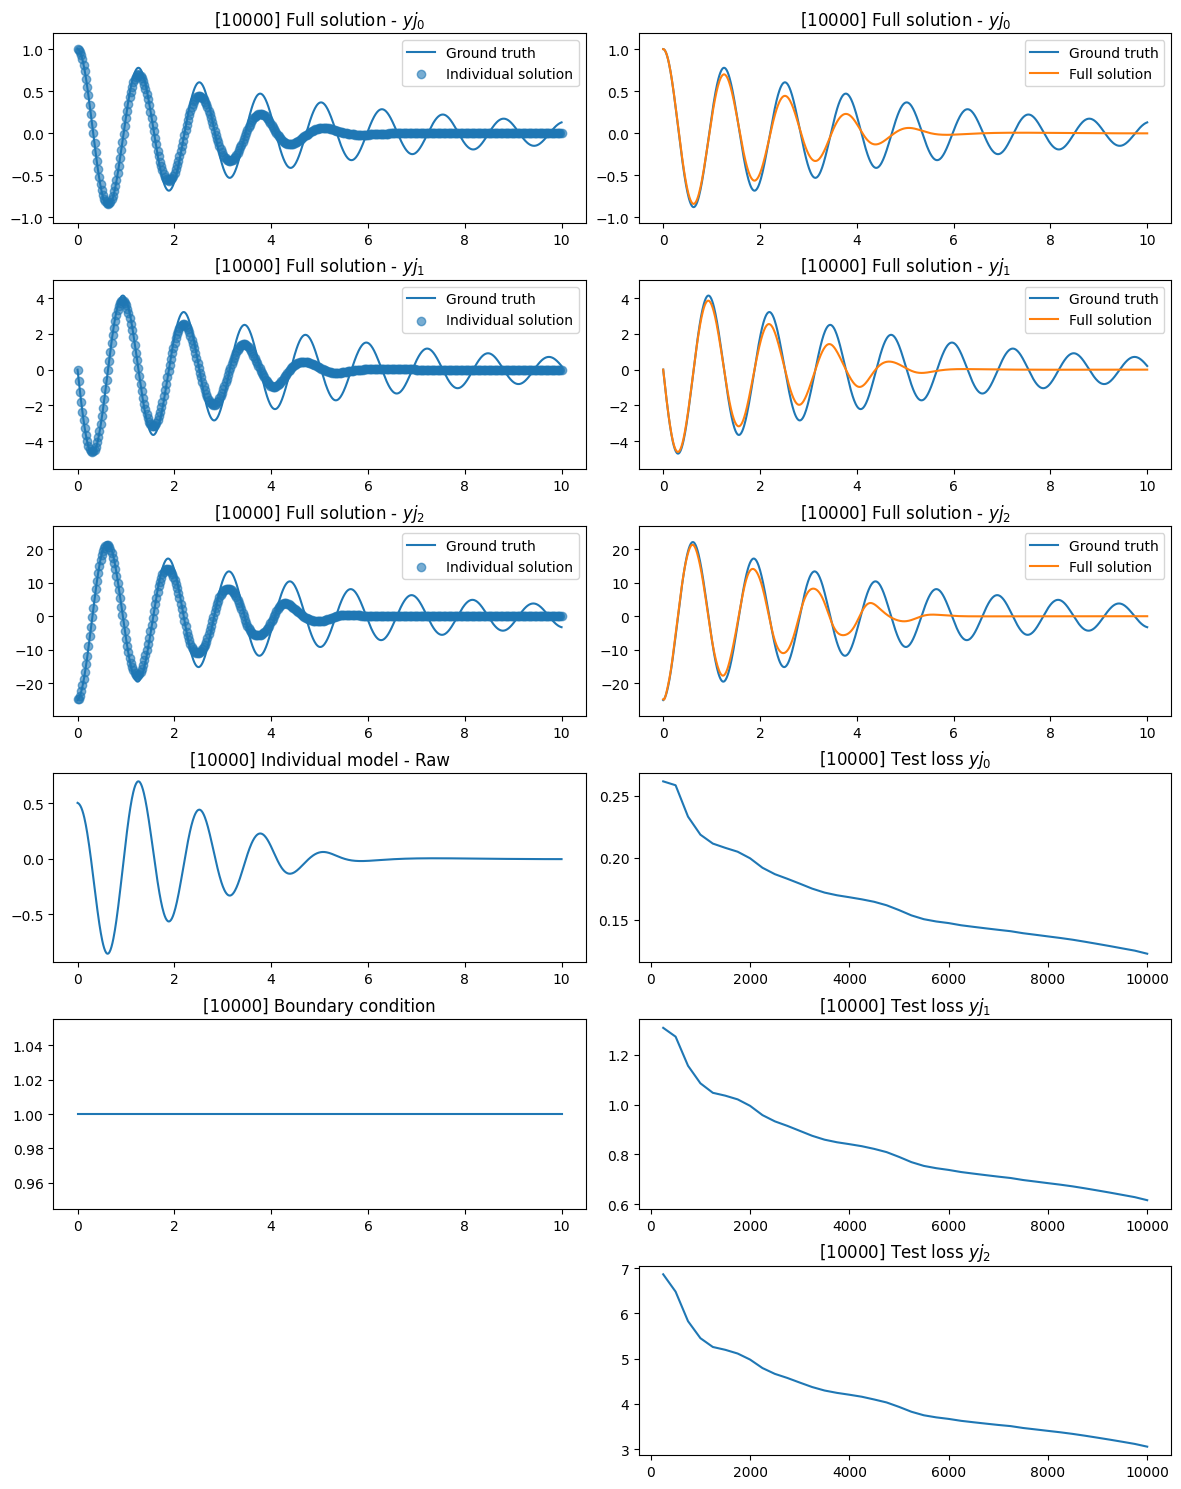

Finished training


In [4]:
# compare to PINN
run = PINNTrainer(c2)
run.train()

# finally, compare runs by plotting saved test losses

fbpinn_loss = np.load("results/models/%s/loss_%.8i.npy"%(c1.RUN, 10000))
pinn_loss   = np.load("results/models/%s/loss_%.8i.npy"%(c2.RUN, 10000))

plt.figure(figsize=(7,5))
plt.plot(fbpinn_loss[:,0], fbpinn_loss[:,3], label=c1.RUN)
plt.plot(pinn_loss[:,0], pinn_loss[:,3], label=c2.RUN)
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("L1 loss")
plt.legend()
plt.title("Test loss")
plt.show()